# Concept Drift Detection Methods Benchmark

In [1]:
# Dependencies and Setup

import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import psutil
import gc
from collections import deque
import sys
import os

# matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Scikit-learn imports
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# River imports
from river import compose, linear_model, preprocessing, metrics
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# Setup paths for local modules
sys.path.insert(0, os.path.abspath('../backup'))

# Import original implementations
from gen_data import gen_random
from dawidd import dawidd
from shape_dd import shape
from d3 import d3

# Random seed configuration
RANDOM_SEED = 999

# Configuration
plt.style.use('seaborn-v0_8')
np.random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')



In [2]:
def calculate_prequential_accuracy(predictions, true_labels, window_size=100):
    """Calculate prequential (test-then-train) accuracy over time."""
    accuracies = []
    for i in range(len(predictions)):
        start_idx = max(0, i - window_size + 1)
        window_preds = predictions[start_idx:i+1]
        window_true = true_labels[start_idx:i+1]
        
        if len(window_preds) > 0:
            accuracy = np.mean(np.array(window_preds) == np.array(window_true))
            accuracies.append(accuracy)
        else:
            accuracies.append(0.0)
    
    return accuracies


In [3]:
def calculate_mttd_metrics(detections, true_drifts, acceptable_delta=100, allow_early_detection=True):
    """
    Calculate Mean Time To Detection and TP/FP/FN metrics with improved one-to-one matching.
    
    Parameters:
    -----------
    detections : list
        List of detection timestamps
    true_drifts : list
        List of true drift timestamps  
    acceptable_delta : int, default=100
        Maximum acceptable delay for a detection to be considered valid
    allow_early_detection : bool, default=True
        Whether to allow detections slightly before true drifts (within acceptable_delta/2)
        
    Returns:
    --------
    dict : Performance metrics including MTTD, precision, recall, TP/FP/FN
    """
    if true_drifts is None:
        true_drifts = []

    sorted_drifts = sorted(int(d) for d in true_drifts)
    sorted_detections = sorted(int(d) for d in detections)

    if len(sorted_drifts) == 0:
        return {
            'ground_truth_available': False,
            'mttd': np.nan,
            'tp': np.nan,
            'fp': np.nan,
            'fn': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'detection_delays': [],
            'acceptable_delta': acceptable_delta
        }

    # Enhanced matching with Hungarian algorithm-like approach
    # For each drift, find all valid detections within acceptable window
    valid_matches = {}  # drift_idx -> [(det_idx, delay), ...]
    
    for drift_idx, drift in enumerate(sorted_drifts):
        valid_matches[drift_idx] = []
        
        for det_idx, detection in enumerate(sorted_detections):
            delay = detection - drift
            
            # Allow early detection within half the acceptable window
            min_delay = -acceptable_delta // 2 if allow_early_detection else 0
            max_delay = acceptable_delta
            
            if min_delay <= delay <= max_delay:
                valid_matches[drift_idx].append((det_idx, delay))
    
    # Greedy assignment: prioritize shortest delays and unused detections
    tp = 0
    fn = 0
    used_detection_idx = set()
    detection_delays = []
    matched_pairs = []  # For debugging/analysis
    
    # Sort drifts by number of available matches (fewer options first)
    drift_priorities = sorted(valid_matches.keys(), 
                             key=lambda d: len(valid_matches[d]))
    
    for drift_idx in drift_priorities:
        drift = sorted_drifts[drift_idx]
        available_matches = [
            (det_idx, delay) for det_idx, delay in valid_matches[drift_idx]
            if det_idx not in used_detection_idx
        ]
        
        if available_matches:
            # Choose the detection with minimum absolute delay
            best_det_idx, best_delay = min(available_matches, key=lambda x: abs(x[1]))
            
            tp += 1
            detection_delays.append(float(best_delay))
            used_detection_idx.add(best_det_idx)
            matched_pairs.append((drift, sorted_detections[best_det_idx], best_delay))
        else:
            fn += 1

    # Count false positives (unmatched detections)
    fp = sum(1 for idx in range(len(sorted_detections)) if idx not in used_detection_idx)
    
    # Calculate metrics
    mttd = float(np.mean(detection_delays)) if detection_delays else float('inf')
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # Additional diagnostic information
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'ground_truth_available': True,
        'mttd': mttd,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'detection_delays': detection_delays,
        'acceptable_delta': acceptable_delta,
        'allow_early_detection': allow_early_detection,
        'matched_pairs': matched_pairs,  # For analysis/debugging
        'total_true_drifts': len(sorted_drifts),
        'total_detections': len(sorted_detections)
    }


In [4]:
def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb


In [5]:
def evaluate_window_based_method(
    X, y, true_drifts, method_name, chunk_size=150, overlap=100,
    cooldown=None, d3_threshold=0.5, dawidd_alpha=0.05, shape_alpha=0.05
):
    
    if cooldown is None:
        cooldown = chunk_size // 2

    start_mem = monitor_resources()
    t0_all = time.perf_counter()

    method_detections = []
    runtime_per_batch_ms = []
    drift_estimates = []
    true_drift_scores = []
    true_drift_reference = sorted(int(d) for d in true_drifts) if true_drifts is not None else []

    shift = chunk_size - overlap
    batches = []
    for i in range(int(X.shape[0] / shift) - int(chunk_size / shift) + 1):
        batch_indices = np.arange(i * shift, min(chunk_size + i * shift, X.shape[0]))
        batches.append(batch_indices)

    batch_count = len(batches)
    last_det = -10**9

    # Precompute ShapeDD p-values once per stream
    shape_total_time_ms = 0.0
    if method_name == 'ShapeDD':
        t_shape0 = time.perf_counter()
        shp_full = shape(X, 50, chunk_size, 2500)
        shp_pvals = shp_full[:, 2]
        t_shape1 = time.perf_counter()
        shape_total_time_ms = (t_shape1 - t_shape0) * 1000.0

    for b in batches:
        xb = X[b]
        yb = y[b]
        t1 = time.perf_counter()

        # Drift score replicates the continuous analysis when drift states are supplied
        if len(yb) > 1:
            drift_score = (yb[None, :] != yb[:, None]).sum() / (len(yb) * (len(yb) - 1))
        else:
            drift_score = 0.0
        true_drift_scores.append(float(drift_score))

        try:
            if method_name == 'D3':
                d3_estimates = {
                    'linear': d3(xb),
                    'extra_trees': d3(xb, ExtraTreesClassifier(max_depth=5)),
                    'random_forest': d3(xb, RandomForestClassifier(max_depth=5)),
                    'knn': d3(xb, KNeighborsClassifier())
                }
                est = float(d3_estimates['linear'])
                trigger = est > d3_threshold
                det_pos = b[-1]

            elif method_name == 'DAWIDD':
                _, est = dawidd(xb, 'rbf')
                est = float(est)
                trigger = est < dawidd_alpha
                det_pos = b[-1]

            elif method_name == 'ShapeDD':
                batch_pvals = shp_pvals[b]
                est = float(batch_pvals.min())
                trigger = est < shape_alpha
                det_pos = b[int(np.argmin(batch_pvals))]

            else:
                raise ValueError(f'Unknown window method: {method_name}')

        except Exception as exc:
            print(f'Error in {method_name}: {exc}')
            est, trigger, det_pos = 0.0, False, b[-1]

        drift_estimates.append(est)

        if trigger and (det_pos - last_det >= cooldown):
            method_detections.append(int(det_pos))
            last_det = det_pos

        batch_ms = (time.perf_counter() - t1) * 1000.0
        if method_name == 'ShapeDD':
            batch_ms += shape_total_time_ms / max(1, batch_count)
        runtime_per_batch_ms.append(batch_ms)

    total_time_s = time.perf_counter() - t0_all
    end_mem = monitor_resources()
    memory_mb = max(0.0, end_mem - start_mem)

    estimate_correlation = 0.0
    if len(drift_estimates) > 1 and len(true_drift_scores) > 1:
        try:
            est_arr = np.asarray(drift_estimates, dtype=float)
            tds_arr = np.asarray(true_drift_scores, dtype=float)
            if len(est_arr) == len(tds_arr) and np.std(est_arr) > 0 and np.std(tds_arr) > 0:
                estimate_correlation = np.corrcoef(est_arr, tds_arr)[0, 1]
                if method_name in ['DAWIDD', 'ShapeDD']:
                    estimate_correlation = -estimate_correlation
        except Exception as exc:
            print(f'Warning: Could not calculate correlation for {method_name}: {exc}')
            estimate_correlation = 0.0

    mttd_metrics = calculate_mttd_metrics(method_detections, true_drifts)

    return {
        'method': method_name,
        'paradigm': 'window',
        'detections': method_detections,
        'drift_estimates': drift_estimates,
        'true_drift_scores': true_drift_scores,
        'true_drifts_reference': true_drift_reference,
        'estimate_correlation': float(estimate_correlation),
        'runtime_per_batch_ms': float(np.mean(runtime_per_batch_ms)) if runtime_per_batch_ms else 0.0,
        'runtime_per_instance_ms': (total_time_s * 1000.0) / max(1, len(X)),
        'total_runtime_s': total_time_s,
        'memory_mb': memory_mb,
        **mttd_metrics
    }


In [6]:
def evaluate_streaming_method(
    X, y, true_drifts=None, method_name=None, feature_names=None,
    stream_dicts=None, initial_train_period=200, warm_start_window=200,
    detection_cooldown=5, accuracy_window_size=50
):
    if method_name is None:
        raise ValueError('A drift detector name must be provided.')

    start_memory = monitor_resources()
    start_time = time.time()

    def make_detector(name):
        if name == 'ADWIN':
            return ADWIN(delta=0.002)
        if name == 'DDM':
            return DDM()
        if name == 'EDDM':
            return EDDM(alpha=0.95, beta=0.9)
        if name == 'HDDM_A':
            return HDDM_A()
        if name == 'HDDM_W':
            return HDDM_W()
        if name == 'FHDDM':
            return FHDDM(short_window_size=20)
        raise ValueError(f"Unknown streaming method: {name}")

    def make_model():
        return compose.Pipeline(
            preprocessing.OneHotEncoder(),
            linear_model.LogisticRegression()
        )

    # Determine optimal signal type for each detector
    def get_signal_type(detector_name):
        """Return the optimal signal type for each detector."""
        continuous_preferred = {'ADWIN'}
        continuous_capable = {'HDDM_A'}  # Can use both but may benefit from continuous
        binary_optimal = {'DDM', 'EDDM', 'HDDM_W', 'FHDDM'}
        
        if detector_name in continuous_preferred:
            return 'continuous'
        elif detector_name in continuous_capable:
            return 'continuous'  # Use continuous for potentially better performance
        else:
            return 'binary'

    drift_detector = make_detector(method_name)
    model = make_model()
    signal_type = get_signal_type(method_name)

    y_array = np.asarray(y)
    y_list = y_array.tolist()

    if stream_dicts is not None:
        stream_sequence = list(stream_dicts)
    else:
        X_array = np.asarray(X)
        if feature_names is None:
            feature_names = [f'f_{j}' for j in range(X_array.shape[1])]
        stream_sequence = []
        for row in X_array:
            feature_map = {feature_names[idx]: float(row[idx]) for idx in range(len(feature_names))}
            stream_sequence.append(feature_map)

    if len(stream_sequence) != len(y_list):
        raise ValueError('Feature stream and label stream must have the same length.')

    detections = []
    runtime_per_instance = []
    predictions = []
    accuracies = []
    recent_buffer = deque(maxlen=warm_start_window)
    accuracy_metric = metrics.Accuracy()
    true_drift_reference = sorted(int(d) for d in true_drifts) if true_drifts is not None else []
    last_detection_idx = -10**9
    
    # Enhanced signal tracking for different detector types
    accuracy_buffer = deque(maxlen=accuracy_window_size)  # For windowed accuracy calculation
    error_rate_buffer = deque(maxlen=accuracy_window_size)  # For error rate calculation

    for i, (x_raw, y_true_val) in enumerate(zip(stream_sequence, y_list)):
        instance_start = time.time()
        x_dict = dict(x_raw)
        if isinstance(y_true_val, np.generic):
            y_true = y_true_val.item()
        else:
            y_true = y_true_val

        y_pred = model.predict_one(x_dict)
        predictions.append(int(y_pred) if isinstance(y_pred, (np.integer, np.bool_, bool)) else (y_pred if y_pred is not None else 0))

        in_warmup = (i < initial_train_period) or (y_pred is None)
        if not in_warmup:
            is_correct = int(y_pred == y_true)
            accuracies.append(is_correct)
            accuracy_metric.update(y_true, y_pred)
            
            # Update signal buffers
            accuracy_buffer.append(is_correct)
            error_rate_buffer.append(1 - is_correct)
            
            # Prepare optimized signal based on detector type
            if signal_type == 'continuous':
                if method_name == 'ADWIN':
                    # Use windowed accuracy for ADWIN (more sensitive to gradual changes)
                    if len(accuracy_buffer) >= min(10, accuracy_window_size // 2):
                        windowed_accuracy = float(np.mean(accuracy_buffer))
                        signal = windowed_accuracy
                    else:
                        # Fallback to current accuracy for initial samples
                        signal = float(is_correct)
                elif method_name == 'HDDM_A':
                    # Use windowed error rate for HDDM_A (can benefit from continuous signals)
                    if len(error_rate_buffer) >= min(10, accuracy_window_size // 2):
                        windowed_error_rate = float(np.mean(error_rate_buffer))
                        signal = windowed_error_rate
                    else:
                        signal = float(1 - is_correct)
                else:
                    # Default continuous signal (error rate)
                    signal = float(1 - is_correct)
            else:
                # Binary signal for methods that prefer it
                signal = bool(1 - is_correct)  # Error signal (True = error, False = correct)

            # Update drift detector with optimized signal
            drift_detector.update(signal)

            if drift_detector.drift_detected and (i - last_detection_idx) >= detection_cooldown:
                detections.append(i)
                last_detection_idx = i
                
                # Model restart with warm start
                tail_samples = list(recent_buffer)[-min(50, len(recent_buffer)):]
                drift_detector = make_detector(method_name)
                model = make_model()
                recent_buffer.clear()
                recent_buffer.extend(tail_samples)
                
                # Clear signal buffers for fresh start
                accuracy_buffer.clear()
                error_rate_buffer.clear()
                
                # Retrain on recent samples
                for x_hist, y_hist in tail_samples:
                    model.learn_one(dict(x_hist), y_hist)
        else:
            accuracies.append(0)

        model.learn_one(x_dict, y_true)
        recent_buffer.append((dict(x_dict), y_true))

        instance_time = (time.time() - instance_start) * 1000.0
        runtime_per_instance.append(instance_time)

    total_time = time.time() - start_time
    end_memory = monitor_resources()
    memory_usage = max(0.0, end_memory - start_memory)

    mttd_metrics = calculate_mttd_metrics(detections, true_drifts)

    post_burnin_start = min(initial_train_period, len(accuracies))
    post_burnin_accuracies = accuracies[post_burnin_start:]
    moving_accuracy = float(np.mean(post_burnin_accuracies)) if post_burnin_accuracies else 0.0
    accuracy_std = float(np.std(post_burnin_accuracies)) if post_burnin_accuracies else 0.0
    prequential_accuracy = accuracy_metric.get() if getattr(accuracy_metric, 'n_samples', 0) > 0 else 0.0

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': float(np.mean(runtime_per_instance)) if runtime_per_instance else 0.0,
        'total_runtime_s': total_time,
        'memory_mb': memory_usage,
        'prequential_accuracy': prequential_accuracy,
        'moving_accuracy': moving_accuracy,
        'accuracy_std': accuracy_std,
        'predictions': predictions,
        'accuracies': accuracies,
        'true_drifts_reference': true_drift_reference,
        'signal_type_used': signal_type,  # For debugging/analysis
        'accuracy_window_size': accuracy_window_size,  # For reproducibility
        **mttd_metrics
    }


In [7]:
unified_scenarios = [
    {
        'name': 'Common_Drift',
        'params': {'dist': 'unif', 'intens': 1, 'number': 1, 'alt': True, 'length': 1000, 'dims': 3}
    }
]

# Methods to evaluate
window_methods = ['D3', 'DAWIDD', 'ShapeDD']
streaming_methods = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']


In [8]:
def make_labels(X, e, angle_step_deg=25.0, bias=0.0, noise_rate=0.01, seed=42):
    rng = np.random.default_rng(seed)
    X = np.asarray(X)
    e = np.asarray(e)
    n, d = X.shape
    if d < 2:
        score = X.sum(axis=1) - bias
        y = (score > 0).astype(int)
    else:
        phi = np.deg2rad(angle_step_deg) * e
        w0 = np.cos(phi)
        w1 = np.sin(phi)
        score = w0 * X[:, 0] + w1 * X[:, 1] - bias
        y = (score > 0).astype(int)

    if noise_rate and noise_rate > 0:
        flips = rng.random(n) < noise_rate
        y[flips] ^= 1
    return y


In [9]:
# Process the scenario from unified_scenarios
scenario = unified_scenarios[0]  # Use the first (and only) scenario
scenario_name = scenario['name']
params = scenario['params']

label_config = scenario.get('label_config', {
    'angle_step_deg': 25.0,
    'bias': 1.255,
    'noise_rate': 0.05,
    'seed': RANDOM_SEED,
})


In [10]:
# Generate data
X, e = gen_random(**params)
y = make_labels(X, e, **label_config)
# Calculate true drift positions from the drift indicator
true_drifts = np.where(np.diff(e) != 0)[0] + 1
stream_feature_names = [f'x_{idx}' for idx in range(X.shape[1])]


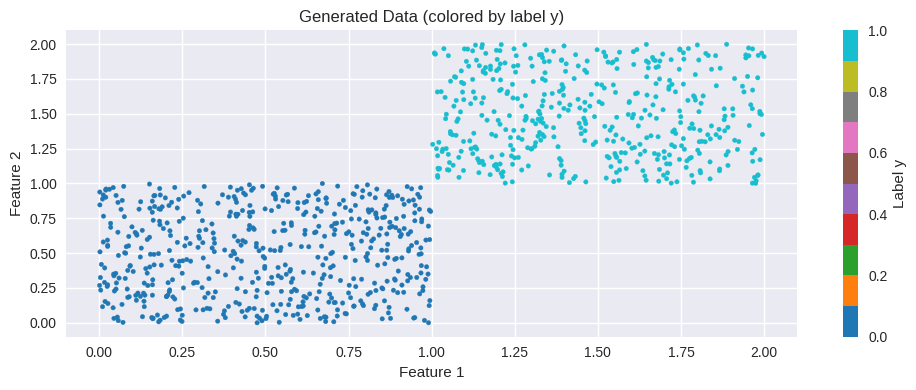

In [11]:
plt.figure(figsize=(10, 4))
if X.shape[1] == 1:
    plt.scatter(range(len(X)), X[:, 0], c=e, cmap='tab10', s=10)
    plt.xlabel('Sample Index')
    plt.ylabel('Feature Value')
elif X.shape[1] == 2:
    plt.scatter(X[:, 0], X[:, 1], c=e, cmap='tab10', s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
else:
    # For higher dimensions, plot first two features colored by y
    plt.scatter(X[:, 0], X[:, 1], c=e, cmap='tab10', s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
plt.title('Generated Data (colored by label y)')
plt.colorbar(label='Label y')
plt.tight_layout()
plt.show()


In [12]:
def run_unified_experiment(scenario_config):
    print(f"  Data: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  True drifts at: {list(true_drifts)}")
    
    results = []
    
    # Evaluate window-based methods
    for method_name in window_methods:
        print(f"  Running {method_name}")
        result = evaluate_window_based_method(X, e, true_drifts, method_name)
        result['scenario'] = scenario_name
        results.append(result)
    
    # Evaluate streaming methods
    for method_name in streaming_methods:
        print(f"  Running {method_name}")
        result = evaluate_streaming_method(
            X,
            y,
            true_drifts,
            method_name,
            feature_names=stream_feature_names
        )
        result['scenario'] = scenario_name
        results.append(result)
    
    # Force garbage collection
    gc.collect()
    
    return results


In [13]:
all_unified_results = []

scenario_results = run_unified_experiment(scenario)
all_unified_results.extend(scenario_results)
    
print(f"Completed scenario: {scenario['name']}")

# Convert to DataFrame
unified_df = pd.DataFrame(all_unified_results)


  Data: 1000 samples, 3 features
  True drifts at: [np.int64(548)]
  Running D3
  Running DAWIDD
  Running ShapeDD
  Running ADWIN
  Running DDM
  Running EDDM
  Running HDDM_A
  Running HDDM_W
  Running FHDDM
Completed scenario: Common_Drift


In [14]:
# Extract true drifts from the first scenario (since we know the data generation parameters)
scenario_params = unified_scenarios[0]['params']  # Get the parameters used

print(f"Extracted {len(true_drifts)} true drift points: {list(true_drifts)}")

# Calculate F1-score
unified_df['f1_score'] = 2 * unified_df['precision'] * unified_df['recall'] / (unified_df['precision'] + unified_df['recall'])
unified_df['f1_score'] = unified_df['f1_score'].fillna(0)

# Academic summary table
summary_table = unified_df.groupby(['paradigm', 'method']).agg({
    'precision': 'mean',
    'recall': 'mean', 
    'f1_score': 'mean',
    'mttd': lambda x: np.mean(x[x != float('inf')]) if any(x != float('inf')) else float('inf'),
    'runtime_per_instance_ms': 'mean',
    'tp': 'sum',
    'fp': 'sum',
    'fn': 'sum'
}).round(4)

print("\nPerformance Metrics by Method")
print(f"{'Method':<12} {'Paradigm':<10} {'Precision':<10} {'Recall':<8} {'F1':<8} {'MTTD':<8} {'Runtime(ms)':<12}")

for (paradigm, method), row in summary_table.iterrows():
    mttd_str = f"{row['mttd']:.1f}" if row['mttd'] != float('inf') else "∞"
    print(f"{method:<12} {paradigm:<10} {row['precision']:<10.3f} {row['recall']:<8.3f} "
            f"{row['f1_score']:<8.3f} {mttd_str:<8} {row['runtime_per_instance_ms']:<12.4f}")


Extracted 1 true drift points: [np.int64(548)]

Performance Metrics by Method
Method       Paradigm   Precision  Recall   F1       MTTD     Runtime(ms) 
ADWIN        streaming  1.000      1.000    1.000    35.0     0.8192      
DDM          streaming  0.250      1.000    0.400    4.0      0.5169      
EDDM         streaming  1.000      1.000    1.000    12.0     0.7615      
FHDDM        streaming  0.000      0.000    0.000    ∞        0.9597      
HDDM_A       streaming  1.000      1.000    1.000    35.0     0.7811      
HDDM_W       streaming  1.000      1.000    1.000    10.0     0.7681      
D3           window     0.000      0.000    0.000    ∞        2.4340      
DAWIDD       window     0.500      1.000    0.667    1.0      1.1031      
ShapeDD      window     1.000      1.000    1.000    -2.0     0.0444      


In [15]:
# Define colors and markers
colors = {'window': '#2E86AB', 'streaming': '#A23B72'}  # Professional blue/burgundy
markers = {'window': 'o', 'streaming': 's'}


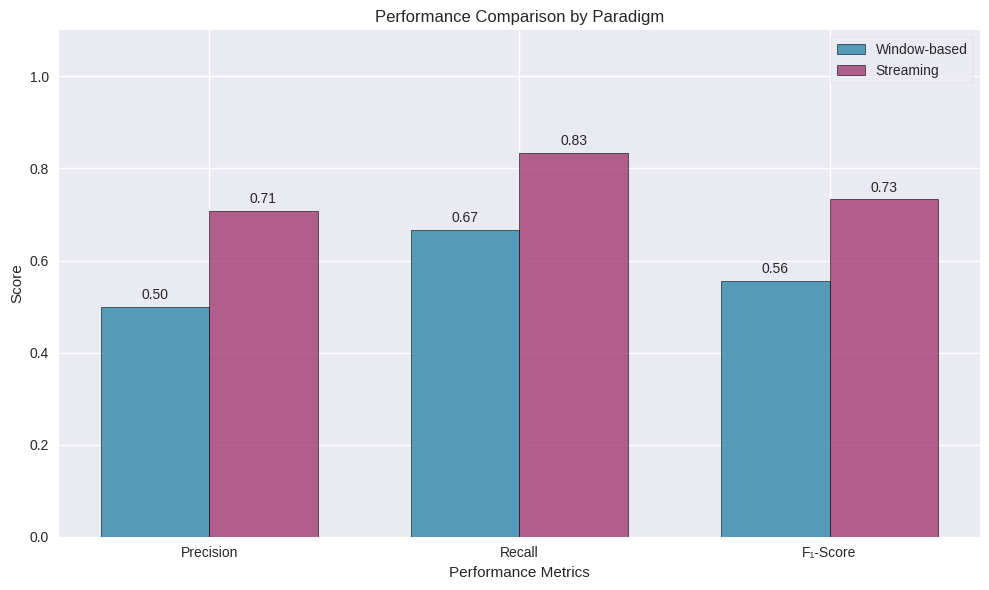

In [16]:
# Plot 1: Performance Comparison by Paradigm
plt.figure(figsize=(10, 6))
metric_keys = ['precision', 'recall', 'f1_score']
metric_labels = ['Precision', 'Recall', 'F₁-Score']

x = np.arange(len(metric_labels))
width = 0.35

window_means = [unified_df[unified_df['paradigm'] == 'window'][m].mean() for m in metric_keys]
streaming_means = [unified_df[unified_df['paradigm'] == 'streaming'][m].mean() for m in metric_keys]

bars1 = plt.bar(x - width/2, window_means, width, label='Window-based', 
                color=colors['window'], alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = plt.bar(x + width/2, streaming_means, width, label='Streaming', 
                color=colors['streaming'], alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels on bars
for i, (w_val, s_val) in enumerate(zip(window_means, streaming_means)):
    plt.text(i - width/2, w_val + 0.01, f'{w_val:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2, s_val + 0.01, f'{s_val:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison by Paradigm')
plt.xticks(x, metric_labels)
plt.legend(frameon=True, fancybox=False, shadow=False)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


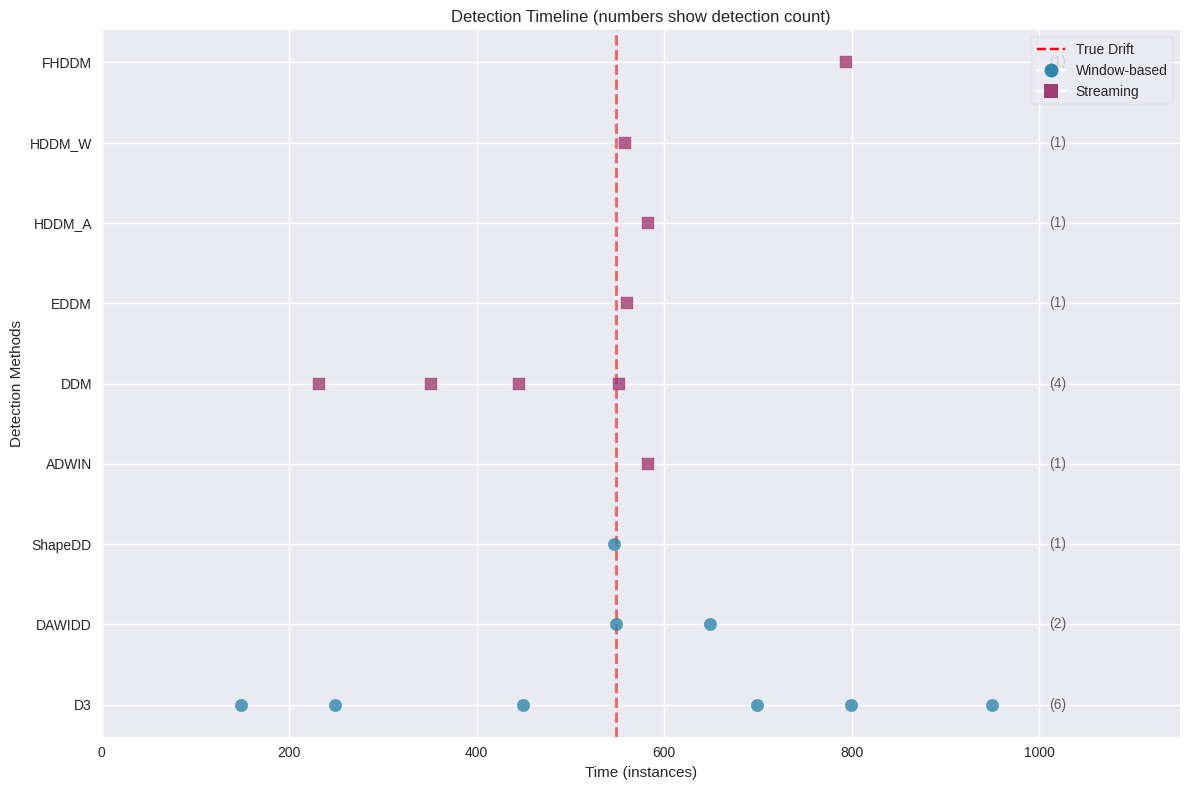

In [17]:
# Plot 2: Detection Timeline Analysis
plt.figure(figsize=(12, 8))

# Plot true drifts as vertical lines
for drift in true_drifts:
    plt.axvline(x=drift, color='red', linestyle='--', alpha=0.6, linewidth=2, zorder=1)

# Create method mapping for y-positions with clear labels
method_names = []
y_positions = []
y_pos = 0

# Process window methods first, then streaming
for paradigm in ['window', 'streaming']:
    paradigm_data = unified_df[unified_df['paradigm'] == paradigm]
    for _, row in paradigm_data.iterrows():
        method_name = f"{row['method']}"
        method_names.append(method_name)
        y_positions.append(y_pos)
        
        detections = row['detections']
        if len(detections) > 0:
            plt.scatter(detections, [y_pos] * len(detections), 
                        c=colors[paradigm], marker=markers[paradigm], 
                        s=80, alpha=0.8, zorder=2, 
                        label=f"{paradigm.title()}" if method_name == paradigm_data.iloc[0]['method'] else "")
        
        # Add detection count annotation
        if len(detections) > 0:
            plt.text(scenario_params['length'] * 1.01, y_pos, f"({len(detections)})", 
                    va='center', fontsize=10, alpha=0.7)
        
        y_pos += 1

plt.xlabel('Time (instances)')
plt.ylabel('Detection Methods')
plt.title('Detection Timeline (numbers show detection count)')
plt.xlim(0, scenario_params['length'] * 1.15)
plt.yticks(range(len(method_names)), method_names, fontsize=10)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', linestyle='--', label='True Drift'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['window'], 
                        markersize=10, label='Window-based'),
                    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors['streaming'], 
                        markersize=10, label='Streaming')]
plt.legend(handles=legend_elements, frameon=True, loc='upper right')
plt.tight_layout()
plt.show()


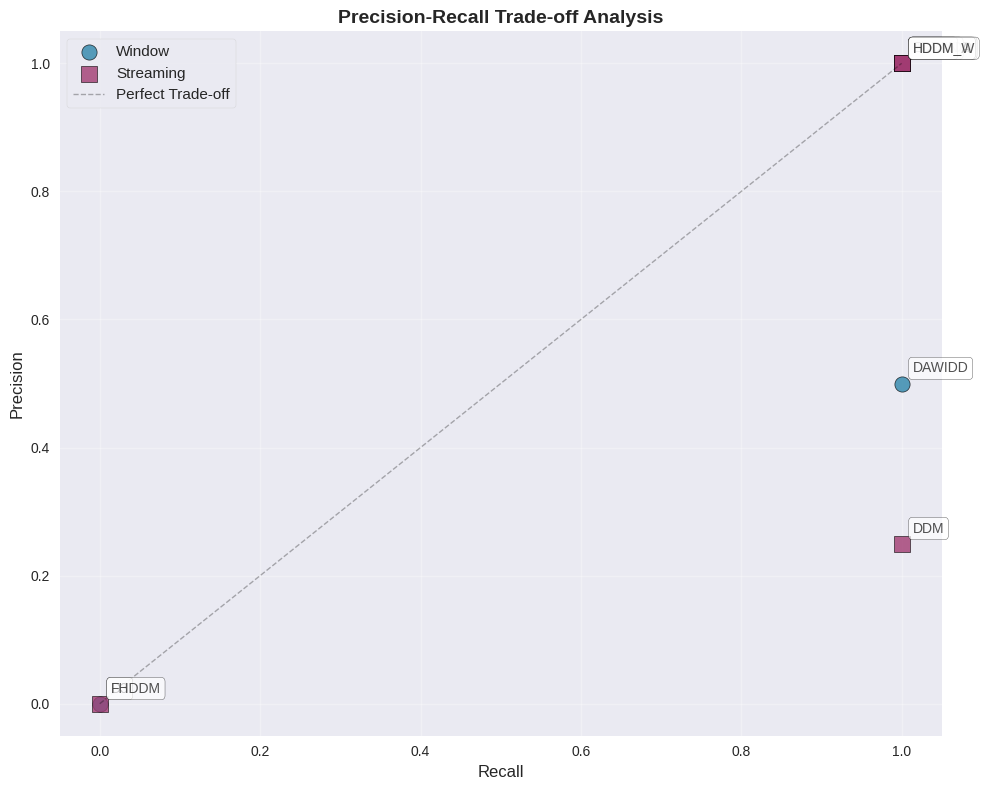

In [18]:
# Plot 3: Precision-Recall Trade-off Analysis
plt.figure(figsize=(10, 8))

for paradigm in ['window', 'streaming']:
    data = unified_df[unified_df['paradigm'] == paradigm]
    scatter = plt.scatter(data['recall'], data['precision'], 
                        c=colors[paradigm], marker=markers[paradigm], s=120, 
                        alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
    
    # Add method labels
    for _, row in data.iterrows():
        plt.annotate(row['method'], (row['recall'], row['precision']), 
                    xytext=(8, 8), textcoords='offset points', fontsize=10, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Add diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1, label='Perfect Trade-off')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Trade-off Analysis', fontsize=14, fontweight='bold')
plt.legend(frameon=True, fontsize=11)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


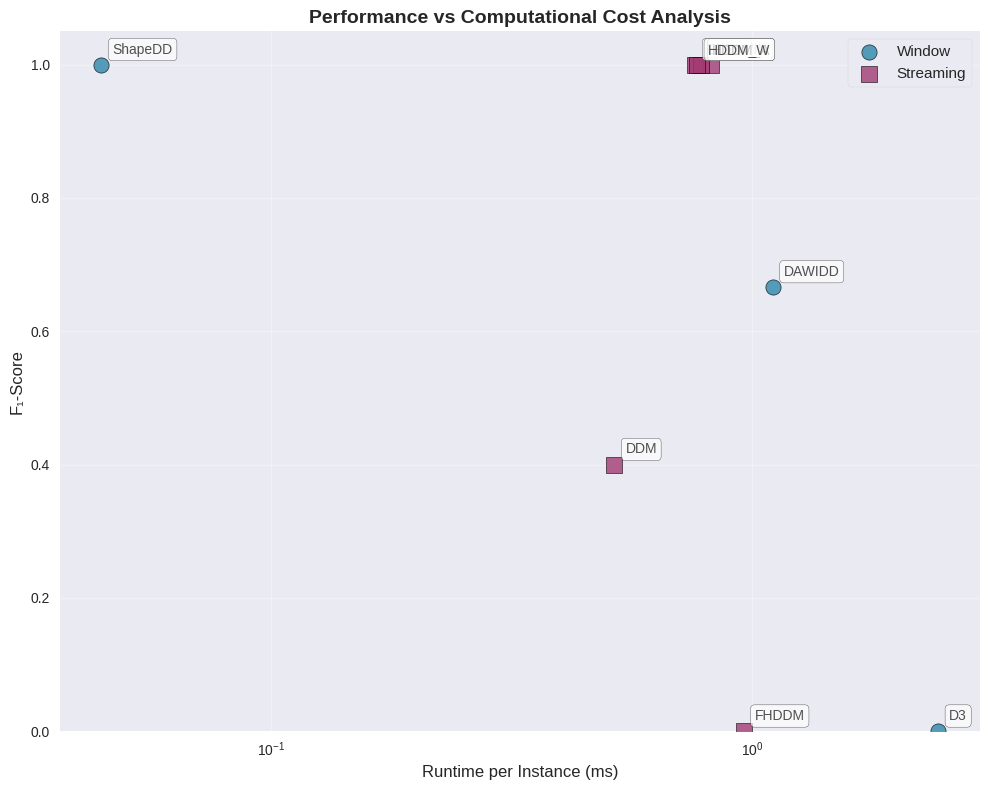

In [19]:
# Plot 4: Performance vs Computational Cost Analysis
plt.figure(figsize=(10, 8))

for paradigm in ['window', 'streaming']:
    data = unified_df[unified_df['paradigm'] == paradigm]
    scatter = plt.scatter(data['runtime_per_instance_ms'], data['f1_score'], 
                        c=colors[paradigm], marker=markers[paradigm], s=120, 
                        alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
    
    # Add method labels
    for _, row in data.iterrows():
        plt.annotate(row['method'], (row['runtime_per_instance_ms'], row['f1_score']), 
                    xytext=(8, 8), textcoords='offset points', fontsize=10, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.xlabel('Runtime per Instance (ms)', fontsize=12)
plt.ylabel('F₁-Score', fontsize=12)
plt.title('Performance vs Computational Cost Analysis', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.legend(frameon=True, fontsize=11)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


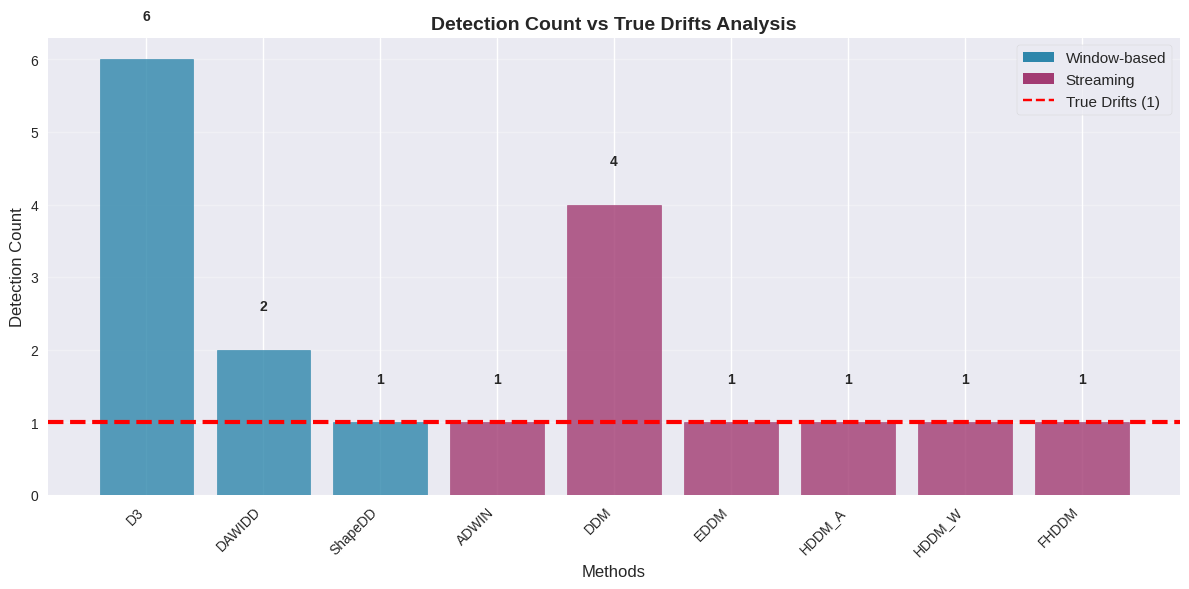

In [20]:
# Plot 5: Detection Count vs True Drifts Analysis
plt.figure(figsize=(12, 6))

methods = unified_df['method'].tolist()
detection_counts = [len(row['detections']) for _, row in unified_df.iterrows()]
true_drift_count = len(true_drifts)

bars = plt.bar(range(len(methods)), detection_counts, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.axhline(y=true_drift_count, color='red', linestyle='--', linewidth=3,
            label=f'True Drifts ({true_drift_count})')

# Color bars by paradigm
for i, (_, row) in enumerate(unified_df.iterrows()):
    color = colors[row['paradigm']]
    bars[i].set_color(color)
    # Add count labels on bars
    plt.text(i, detection_counts[i] + 0.5, str(detection_counts[i]), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Methods', fontsize=12)
plt.ylabel('Detection Count', fontsize=12)
plt.title('Detection Count vs True Drifts Analysis', fontsize=14, fontweight='bold')
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')

# Create custom legend for paradigms
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['window'], label='Window-based'),
                   plt.Rectangle((0,0),1,1, facecolor=colors['streaming'], label='Streaming'),
                   plt.Line2D([0], [0], color='red', linestyle='--', label=f'True Drifts ({true_drift_count})')]
plt.legend(handles=legend_elements, frameon=True, fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


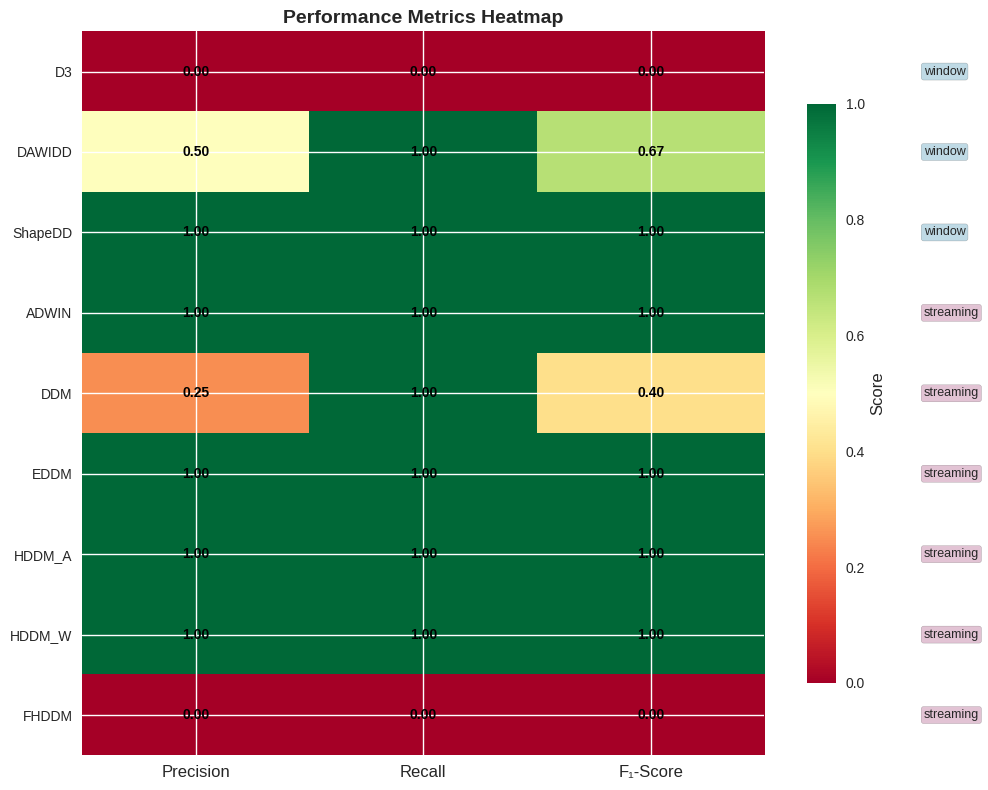

In [21]:
# Plot 6: Performance Metrics Heatmap
plt.figure(figsize=(10, 8))

metrics_data = unified_df[['precision', 'recall', 'f1_score']].values
methods = unified_df['method'].tolist()

im = plt.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
plt.xticks(range(3), ['Precision', 'Recall', 'F₁-Score'], fontsize=12)
plt.yticks(range(len(methods)), methods, fontsize=10)
plt.title('Performance Metrics Heatmap', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Score', fontsize=12)

# Add text annotations
for i in range(len(methods)):
    for j in range(3):
        text = plt.text(j, i, f'{metrics_data[i, j]:.2f}',
                        ha="center", va="center", color="black", fontweight='bold', fontsize=10)

# Add paradigm indicators on the right
for i, (_, row) in enumerate(unified_df.iterrows()):
    paradigm = row['paradigm']
    plt.text(3.2, i, paradigm, ha='left', va='center', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', facecolor=colors[paradigm], alpha=0.3))

plt.tight_layout()
plt.show()


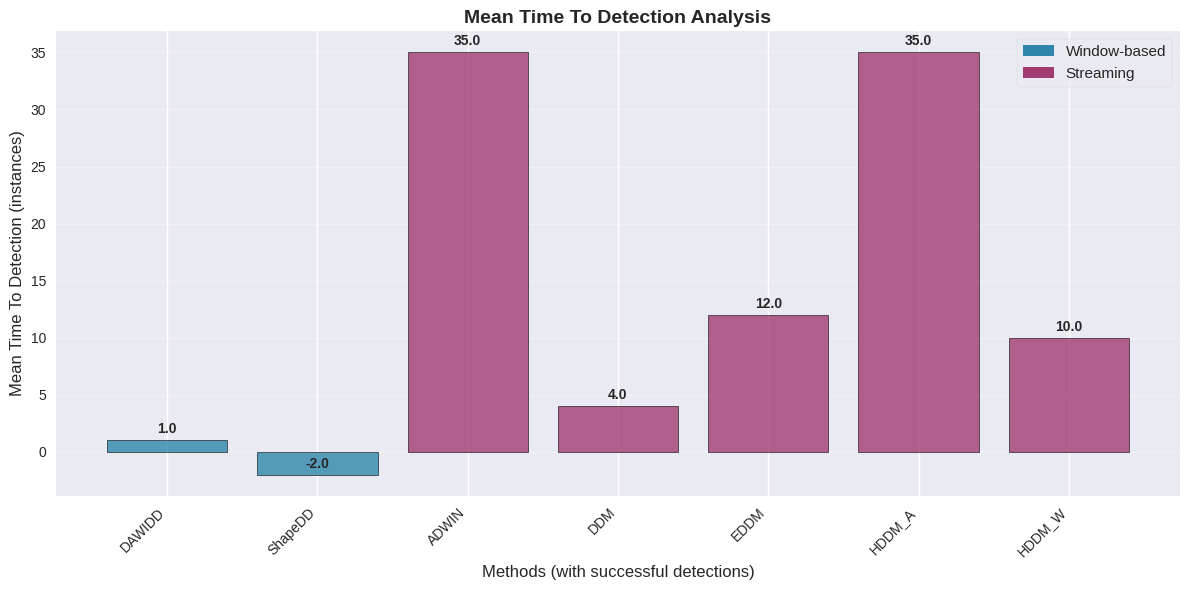

In [22]:
# Plot 7: Mean Time To Detection Analysis
plt.figure(figsize=(12, 6))

mttd_values = []
method_labels = []
colors_list = []
paradigm_list = []

for _, row in unified_df.iterrows():
    if row['mttd'] != float('inf'):
        mttd_values.append(row['mttd'])
        method_labels.append(row['method'])
        colors_list.append(colors[row['paradigm']])
        paradigm_list.append(row['paradigm'])

if mttd_values:
    bars = plt.bar(range(len(mttd_values)), mttd_values, color=colors_list, alpha=0.8, 
                   edgecolor='black', linewidth=0.5)
    plt.xlabel('Methods (with successful detections)', fontsize=12)
    plt.ylabel('Mean Time To Detection (instances)', fontsize=12)
    plt.title('Mean Time To Detection Analysis', fontsize=14, fontweight='bold')
    plt.xticks(range(len(method_labels)), method_labels, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, val in enumerate(mttd_values):
        plt.text(i, val + max(mttd_values) * 0.01, f'{val:.1f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Create custom legend for paradigms
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['window'], label='Window-based'),
                       plt.Rectangle((0,0),1,1, facecolor=colors['streaming'], label='Streaming')]
    plt.legend(handles=legend_elements, frameon=True, fontsize=11)
else:
    plt.text(0.5, 0.5, 'No successful detections\nwith finite MTTD', 
            ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


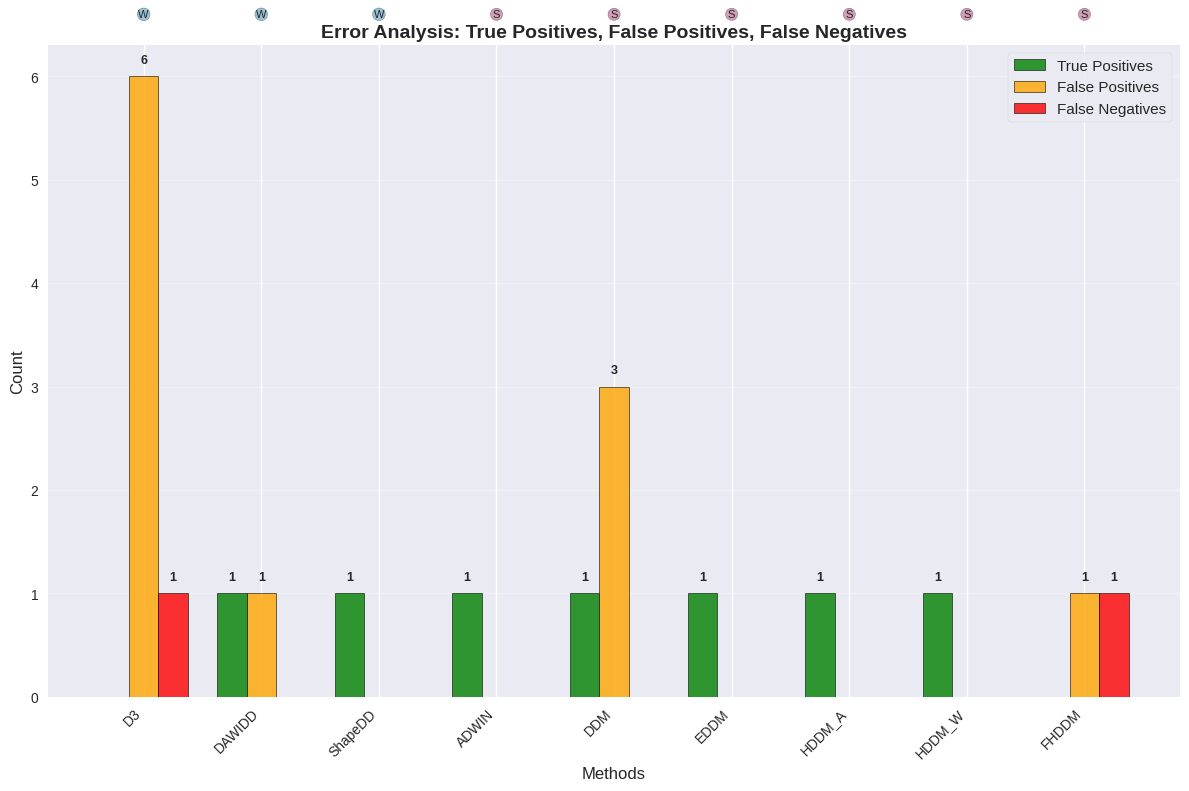

In [23]:
# Plot 8: Error Analysis (TP/FP/FN)
plt.figure(figsize=(12, 8))

methods = unified_df['method'].tolist()
tp_values = unified_df['tp'].tolist()
fp_values = unified_df['fp'].tolist()
fn_values = unified_df['fn'].tolist()

x = np.arange(len(methods))
width = 0.25

bars1 = plt.bar(x - width, tp_values, width, label='True Positives', 
                color='green', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = plt.bar(x, fp_values, width, label='False Positives', 
                color='orange', alpha=0.8, edgecolor='black', linewidth=0.5)
bars3 = plt.bar(x + width, fn_values, width, label='False Negatives', 
                color='red', alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels on bars
for i, (tp, fp, fn) in enumerate(zip(tp_values, fp_values, fn_values)):
    if tp > 0:
        plt.text(i - width, tp + 0.1, str(tp), ha='center', va='bottom', fontsize=9, fontweight='bold')
    if fp > 0:
        plt.text(i, fp + 0.1, str(fp), ha='center', va='bottom', fontsize=9, fontweight='bold')
    if fn > 0:
        plt.text(i + width, fn + 0.1, str(fn), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Methods', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Error Analysis: True Positives, False Positives, False Negatives', fontsize=14, fontweight='bold')
plt.xticks(x, methods, rotation=45, ha='right')
plt.legend(frameon=True, fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add paradigm indicators
for i, (_, row) in enumerate(unified_df.iterrows()):
    paradigm = row['paradigm']
    plt.text(i, max(max(tp_values), max(fp_values), max(fn_values)) * 1.1, 
             paradigm[0].upper(), ha='center', va='center', fontsize=8,
             bbox=dict(boxstyle='circle,pad=0.1', facecolor=colors[paradigm], alpha=0.5))

plt.tight_layout()
plt.show()


In [24]:
# Reset matplotlib parameters to default
plt.rcParams.update(plt.rcParamsDefault)


# Empirical Evaluation on Real-World Datasets

This section evaluates the comparative performance of concept drift detection methods on real-world benchmark datasets from the River library. Unlike controlled synthetic experiments, real-world datasets present inherent challenges including unknown drift timing, varying signal-to-noise ratios, and complex distribution shifts. The evaluation methodology employs prequential learning (test-then-train) to assess detector responsiveness in realistic streaming scenarios.

## Methodology

The evaluation framework integrates standard benchmark datasets (Elec2, AirlinePassengers) directly from the River streaming machine learning library. For datasets without annotated drift locations, detection performance is assessed through computational efficiency metrics, detection frequency patterns, and prequential accuracy maintenance. The window-based methods operate on batch segments while streaming methods process instances sequentially, enabling direct paradigm comparison under identical data conditions.

In [25]:
# Simple Dataset Loading Utilities for Real-World Benchmarks
from river import datasets
import pandas as pd
import numpy as np


In [26]:
datasets.Elec2()


Electricity prices in New South Wales.

This is a binary classification task, where the goal is to predict if the price of electricity
will go up or down.

This data was collected from the Australian New South Wales Electricity Market. In this market,
prices are not fixed and are affected by demand and supply of the market. They are set every
five minutes. Electricity transfers to/from the neighboring state of Victoria were done to
alleviate fluctuations.

      Name  Elec2                                                      
      Task  Binary classification                                      
   Samples  45,312                                                     
  Features  8                                                          
    Sparse  False                                                      
      Path  /home/pk-sdv/river_data/Elec2/electricity.csv              
       URL  https://maxhalford.github.io/files/datasets/electricity.zip
      Size  2.95 MiB               

In [27]:
datasets.AirlinePassengers()


Monthly number of international airline passengers.

The stream contains 144 items and only one single feature, which is the month. The goal is to
predict the number of passengers each month by capturing the trend and the seasonality of the
data.

    Name  AirlinePassengers                                                                                                                            
    Task  Regression                                                                                                                                   
 Samples  144                                                                                                                                          
Features  1                                                                                                                                            
  Sparse  False                                                                                                                                 

In [28]:
df_elec2 = pd.read_csv('../datasets/electricity.csv')
df_elec2


,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN
...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,DOWN
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,DOWN
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,DOWN
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,UP


In [29]:
df_airline = pd.read_csv('../datasets/airline-passengers.csv')
df_airline


,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


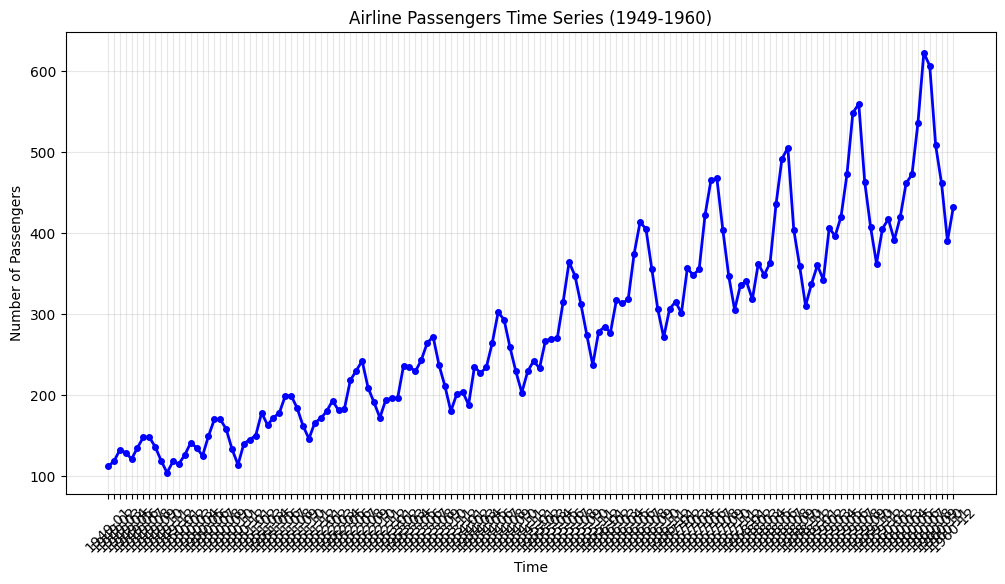

Passenger count range: 104 - 622
Mean passengers: 280.3
Standard deviation: 120.0
Time period: 1949-01 to 1960-12


In [30]:
import matplotlib.pyplot as plt

df_airline_copy = df_airline.copy()

# Convert month to datetime for better plotting
df_airline_copy['month'] = pd.to_datetime(df_airline['month'])
df_airline_copy['passengers'] = df_airline['passengers']

# Plot the AirlinePassengers dataset
plt.figure(figsize=(12, 6))

plt.plot(df_airline['month'], df_airline['passengers'], 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.title('Airline Passengers Time Series (1949-1960)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

# Display basic statistics
print(f"Passenger count range: {df_airline['passengers'].min()} - {df_airline['passengers'].max()}")
print(f"Mean passengers: {df_airline['passengers'].mean():.1f}")
print(f"Standard deviation: {df_airline['passengers'].std():.1f}")
print(f"Time period: {df_airline['month'].min()} to {df_airline['month'].max()}")


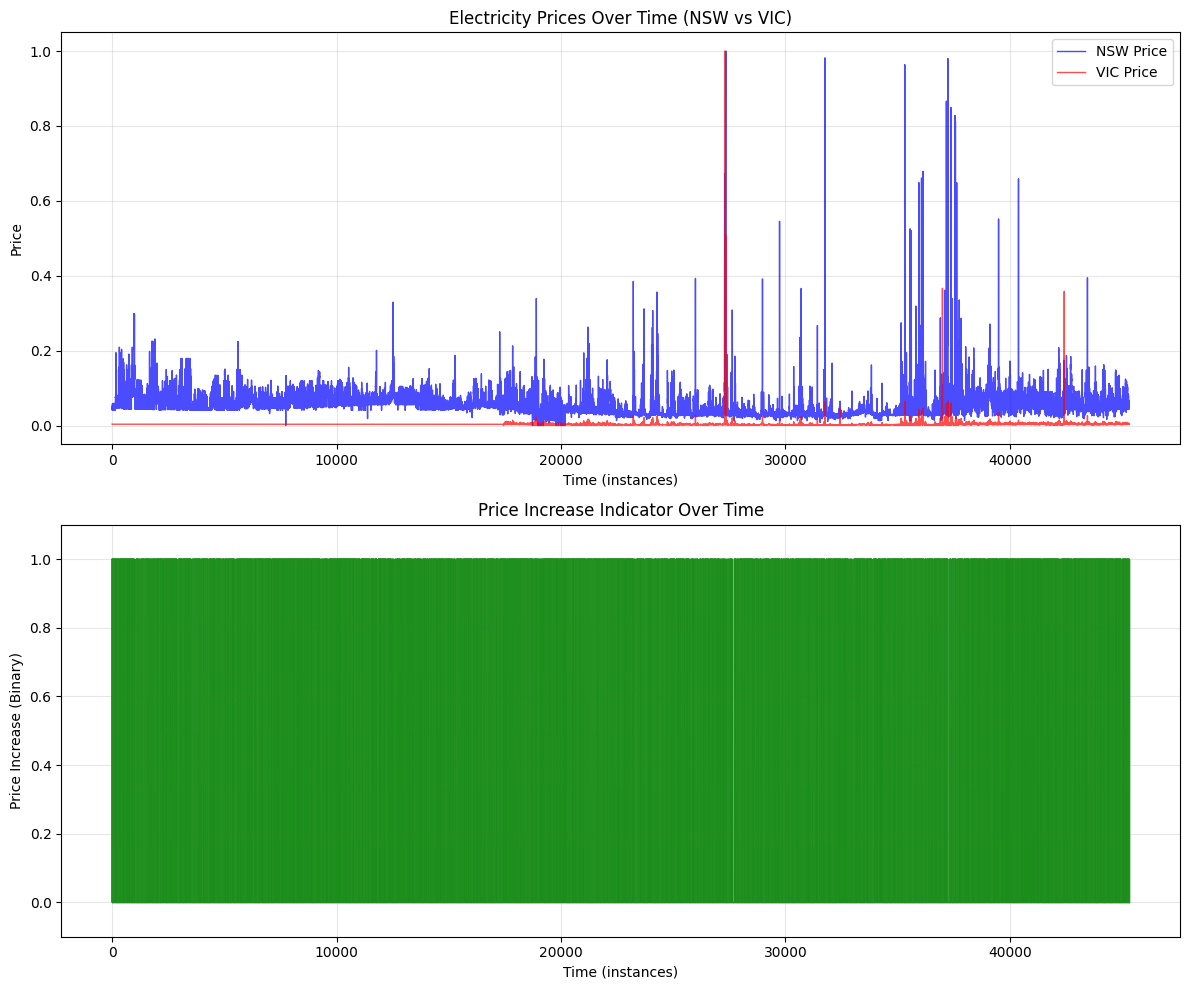

Dataset shape: (45312, 9)
NSW price range: 0.000 - 1.000
VIC price range: 0.000 - 1.000
Price increase rate: 0.425
Class distribution: {0: 26075, 1: 19237}


In [31]:
# Load and prepare Elec2 data for plotting
df_elec2_copy = df_elec2.copy()

# Create a figure with subplots for better visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Price over time
ax1.plot(range(len(df_elec2)), df_elec2_copy['nswprice'], 'b-', linewidth=1, alpha=0.7, label='NSW Price')
ax1.plot(range(len(df_elec2)), df_elec2_copy['vicprice'], 'r-', linewidth=1, alpha=0.7, label='VIC Price')
ax1.set_xlabel('Time (instances)')
ax1.set_ylabel('Price')
ax1.set_title('Electricity Prices Over Time (NSW vs VIC)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Price increase indicator (binary target)

# Convert the binary class to integer for plotting
df_elec2_copy['class'] = df_elec2_copy['class'].map({'UP': 1, 'DOWN': 0})

price_increase = df_elec2_copy['class'].astype(int)
ax2.plot(range(len(df_elec2_copy)), price_increase, 'g-', linewidth=1, alpha=0.8)
ax2.fill_between(range(len(df_elec2_copy)), price_increase, alpha=0.3, color='green')
ax2.set_xlabel('Time (instances)')
ax2.set_ylabel('Price Increase (Binary)')
ax2.set_title('Price Increase Indicator Over Time')
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display basic statistics
print(f"Dataset shape: {df_elec2_copy.shape}")
print(f"NSW price range: {df_elec2_copy['nswprice'].min():.3f} - {df_elec2['nswprice'].max():.3f}")
print(f"VIC price range: {df_elec2_copy['vicprice'].min():.3f} - {df_elec2['vicprice'].max():.3f}")
print(f"Price increase rate: {df_elec2_copy['class'].mean():.3f}")
print(f"Class distribution: {df_elec2_copy['class'].value_counts().to_dict()}")


In [32]:
df_elec2_copy


,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0
...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,0
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,0
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,0
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,1


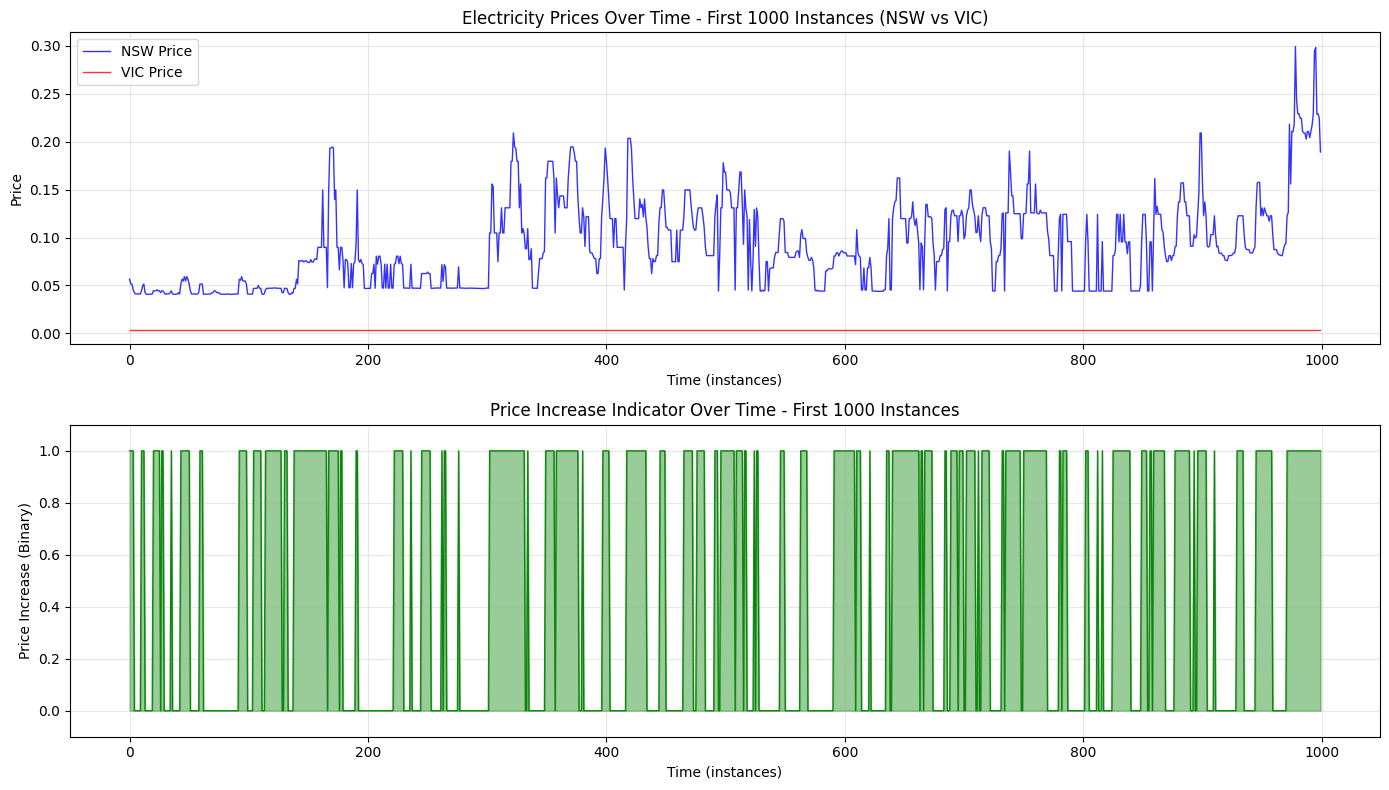

Sample dataset shape: (1000, 9)
Sample NSW price range: 0.041 - 0.299
Sample VIC price range: 0.003 - 0.003
Full dataset has 45,312 instances


In [33]:
# Plot a smaller subset of Elec2 data for better visualization
sample_size = 1000  # Use first 1000 instances for clearer visualization
df_elec2_sample = df_elec2_copy.head(sample_size).copy()

# Create a figure with subplots for better visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Price over time (sample)
ax1.plot(range(len(df_elec2_sample)), df_elec2_sample['nswprice'], 'b-', linewidth=1, alpha=0.8, label='NSW Price')
ax1.plot(range(len(df_elec2_sample)), df_elec2_sample['vicprice'], 'r-', linewidth=1, alpha=0.8, label='VIC Price')
ax1.set_xlabel('Time (instances)')
ax1.set_ylabel('Price')
ax1.set_title(f'Electricity Prices Over Time - First {sample_size} Instances (NSW vs VIC)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Price increase indicator (binary target) - sample
price_increase_sample = df_elec2_sample['class']
ax2.plot(range(len(df_elec2_sample)), price_increase_sample, 'g-', linewidth=1, alpha=0.9)
ax2.fill_between(range(len(df_elec2_sample)), price_increase_sample, alpha=0.4, color='green')
ax2.set_xlabel('Time (instances)')
ax2.set_ylabel('Price Increase (Binary)')
ax2.set_title(f'Price Increase Indicator Over Time - First {sample_size} Instances')
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display sample statistics
print(f"Sample dataset shape: {df_elec2_sample.shape}")
print(f"Sample NSW price range: {df_elec2_sample['nswprice'].min():.3f} - {df_elec2_sample['nswprice'].max():.3f}")
print(f"Sample VIC price range: {df_elec2_sample['vicprice'].min():.3f} - {df_elec2_sample['vicprice'].max():.3f}")
print(f"Full dataset has {len(df_elec2):,} instances")


In [34]:
# Real-World Evaluation Functions (without ground truth)

def evaluate_window_based_method_without_groundtruth(X, method_name):
    """Evaluate window-based methods on real-world data without ground truth."""
    start_time = time.perf_counter()
    start_memory = monitor_resources()
    
    detections = []
    
    try:
        if method_name == 'D3':
            estimate = d3(X)
            # Use adaptive threshold based on data characteristics
            threshold = 0.5
            if estimate > threshold:
                detections.append(len(X) // 2)  # Mark center as detection point
                
        elif method_name == 'DAWIDD':
            _, estimate = dawidd(X, 'rbf')
            threshold = 0.05
            if estimate < threshold:
                detections.append(len(X) // 2)
                
        elif method_name == 'ShapeDD':
            shape_result = shape(X, 50, len(X), 2500)
            if len(shape_result) > 0:
                min_p_value = np.min(shape_result[:, 2])
                threshold = 0.05
                if min_p_value < threshold:
                    # Find all detection points below threshold
                    detection_indices = np.where(shape_result[:, 2] < threshold)[0]
                    detections.extend(detection_indices.tolist())
        
    except Exception as e:
        print(f"    Error in {method_name}: {e}")
        # Return default empty result on error
        pass
    
    total_time = time.perf_counter() - start_time
    end_memory = monitor_resources()
    
    # Calculate metrics without ground truth
    result = {
        'method': method_name,
        'paradigm': 'window',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': (total_time * 1000.0) / len(X),
        'total_runtime_s': total_time,
        'memory_mb': max(0.0, end_memory - start_memory),
        'data_size': len(X)
    }
    
    return result


In [35]:

def evaluate_streaming_method_without_groundtruth(X, method_name, stream_dicts):
    """Evaluate streaming methods on real-world data without ground truth."""
    start_time = time.perf_counter()
    start_memory = monitor_resources()
    
    # Initialize detector based on method
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming method: {method_name}")
    
    # Initialize classifier for accuracy-based signal
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression()
    )
    
    detections = []
    accuracy_scores = []
    
    # Process stream one sample at a time
    for i, (x_dict, y_true) in enumerate(stream_dicts):
        try:
            # Make prediction if model is trained
            if i >= 50:  # Wait for some training data
                y_pred = model.predict_one(x_dict)
                is_correct = (y_pred == y_true) if y_pred is not None else False
                accuracy_scores.append(float(is_correct))
                
                # Prepare signal for detector
                if method_name == 'ADWIN':
                    signal = float(is_correct)  # Accuracy signal for ADWIN
                elif method_name in ['HDDM_A']:
                    signal = float(not is_correct)  # Error rate for HDDM_A
                else:
                    signal = bool(not is_correct)  # Binary error signal for others
                
                # Update detector
                detector.update(signal)
                
                # Check for drift
                if detector.drift_detected:
                    detections.append(i)
            
            # Train model incrementally
            model.learn_one(x_dict, y_true)
            
        except Exception as e:
            if i == 50:  # Only print error once to avoid spam
                print(f"    Warning in {method_name}: {e}")
            continue
    
    total_time = time.perf_counter() - start_time
    end_memory = monitor_resources()
    
    # Calculate final accuracy
    final_accuracy = np.mean(accuracy_scores) if accuracy_scores else 0.0
    
    result = {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': (total_time * 1000.0) / len(X),
        'total_runtime_s': total_time,
        'memory_mb': max(0.0, end_memory - start_memory),
        'final_accuracy': final_accuracy,
        'data_size': len(X)
    }
    
    return result


In [36]:
def run_realworld_experiment(dataset_data, dataset_name):    

    results = []
    
    # Evaluate window-based methods
    for method_name in window_methods:
        print(f"  Running {method_name}")
        result = evaluate_window_based_method_without_groundtruth(
            dataset_data,
            method_name=method_name
        )
        result['dataset'] = dataset_name
        results.append(result)
    
    # TODO: Currently skipping streaming methods on real-world data due to lack of ground truth
    # # Evaluate streaming methods
    # for method_name in streaming_methods:
    #     print(f"  Running {method_name}")
    #     result = evaluate_streaming_method_without_groundtruth(
    #         dataset_data,
    #         method_name=method_name,
    #         stream_dicts=dataset_data['stream_records']
    #     )
    #     result['dataset'] = dataset_name
    #     results.append(result)
    
    # Force garbage collection
    gc.collect()
    
    return results


In [37]:
df_elec2_copy

df_elec2_benchmark = df_elec2_sample.drop(columns=['class']).to_numpy()


In [38]:
df_elec2_benchmark


array([[0.00000e+00, 2.00000e+00, 0.00000e+00, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       [0.00000e+00, 2.00000e+00, 2.12770e-02, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       [0.00000e+00, 2.00000e+00, 4.25530e-02, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       ...,
       [8.85000e-04, 1.00000e+00, 7.87234e-01, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       [8.85000e-04, 1.00000e+00, 8.08511e-01, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       [8.85000e-04, 1.00000e+00, 8.29787e-01, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01]], shape=(1000, 8))

In [39]:
df_airline_copy



,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [40]:
df_airline_benchmark = df_airline_copy['month'].to_numpy().reshape(-1, 1)


In [41]:
df_airline_benchmark


array([['1949-01-01T00:00:00.000000000'],
       ['1949-02-01T00:00:00.000000000'],
       ['1949-03-01T00:00:00.000000000'],
       ['1949-04-01T00:00:00.000000000'],
       ['1949-05-01T00:00:00.000000000'],
       ['1949-06-01T00:00:00.000000000'],
       ['1949-07-01T00:00:00.000000000'],
       ['1949-08-01T00:00:00.000000000'],
       ['1949-09-01T00:00:00.000000000'],
       ['1949-10-01T00:00:00.000000000'],
       ['1949-11-01T00:00:00.000000000'],
       ['1949-12-01T00:00:00.000000000'],
       ['1950-01-01T00:00:00.000000000'],
       ['1950-02-01T00:00:00.000000000'],
       ['1950-03-01T00:00:00.000000000'],
       ['1950-04-01T00:00:00.000000000'],
       ['1950-05-01T00:00:00.000000000'],
       ['1950-06-01T00:00:00.000000000'],
       ['1950-07-01T00:00:00.000000000'],
       ['1950-08-01T00:00:00.000000000'],
       ['1950-09-01T00:00:00.000000000'],
       ['1950-10-01T00:00:00.000000000'],
       ['1950-11-01T00:00:00.000000000'],
       ['1950-12-01T00:00:00.00000

In [42]:
all_realworld_results = []

# for dataset_name, dataset_data in loaded_datasets.items():
#     dataset_results = run_realworld_experiment(dataset_data, dataset_name)
#     all_realworld_results.extend(dataset_results)
#     print(f"Completed {dataset_name}: {len(dataset_results)} method evaluations")

# Methods to evaluate
window_methods = ['D3', 
                #   'DAWIDD', 
                  'ShapeDD']
streaming_methods = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']

dataset_name = 'AirLine'

dataset_results = run_realworld_experiment(df_airline_benchmark, dataset_name)
all_realworld_results.extend(dataset_results)

# Convert to DataFrame for analysis
realworld_df = pd.DataFrame(all_realworld_results)

print(f"\nReal-World Evaluation Summary:")
print(f"   Total evaluations: {len(all_realworld_results)}")
print(f"   Datasets: {realworld_df['dataset'].unique().tolist()}")
print(f"   Methods: {realworld_df['method'].unique().tolist()}")

# Add detection count column for consistency with synthetic results
realworld_df['detection_count'] = realworld_df.apply(
    lambda row: row.get('total_detections', len(row.get('detections', []))), axis=1
)


  Running D3
    Error in D3: ufunc 'matmul' did not contain a loop with signature matching types (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>) -> None
  Running ShapeDD

Real-World Evaluation Summary:
   Total evaluations: 2
   Datasets: ['AirLine']
   Methods: ['D3', 'ShapeDD']


In [43]:
# Display Real-World Results
print("\nReal-World Performance Summary")
print(f"{'Method':<12} {'Dataset':<15} {'Paradigm':<10} {'Detections':<10} {'Runtime(ms)':<12} {'Accuracy':<10}")
print("-" * 80)

for _, row in realworld_df.iterrows():
    accuracy_str = f"{row.get('final_accuracy', 0):.3f}" if 'final_accuracy' in row else "N/A"
    print(f"{row['method']:<12} {row['dataset']:<15} {row['paradigm']:<10} "
          f"{row['detection_count']:<10} {row['runtime_per_instance_ms']:<12.4f} {accuracy_str:<10}")

# Quick statistics
print(f"\nQuick Statistics:")
print(f"   Average detections per method: {realworld_df['detection_count'].mean():.1f}")
print(f"   Average runtime per instance: {realworld_df['runtime_per_instance_ms'].mean():.4f} ms")
print(f"   Methods with detections: {(realworld_df['detection_count'] > 0).sum()}/{len(realworld_df)}")

# Show detection counts by paradigm
window_detections = realworld_df[realworld_df['paradigm'] == 'window']['detection_count'].sum()
streaming_detections = realworld_df[realworld_df['paradigm'] == 'streaming']['detection_count'].sum()
print(f"   Total detections - Window: {window_detections}, Streaming: {streaming_detections}")



Real-World Performance Summary
Method       Dataset         Paradigm   Detections Runtime(ms)  Accuracy  
--------------------------------------------------------------------------------
D3           AirLine         window     0          0.0093       N/A       
ShapeDD      AirLine         window     1          0.0499       N/A       

Quick Statistics:
   Average detections per method: 0.5
   Average runtime per instance: 0.0296 ms
   Methods with detections: 1/2
   Total detections - Window: 1, Streaming: 0


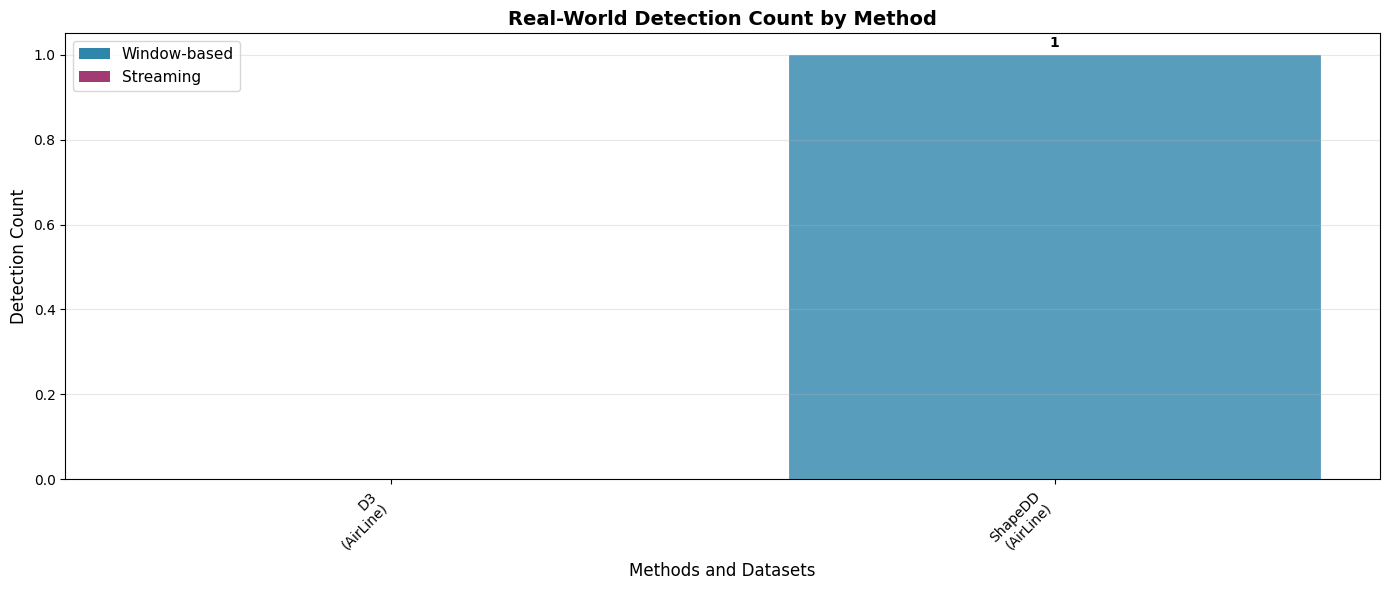

In [44]:
# Real-World Detection Count Visualization
plt.figure(figsize=(14, 6))

methods = [f"{row['method']}\n({row['dataset']})" for _, row in realworld_df.iterrows()]
detection_counts = realworld_df['detection_count'].tolist()

bars = plt.bar(range(len(methods)), detection_counts, alpha=0.8, edgecolor='black', linewidth=0.5)

# Color bars by paradigm (same colors as synthetic)
for i, (_, row) in enumerate(realworld_df.iterrows()):
    color = colors[row['paradigm']]
    bars[i].set_color(color)
    # Add count labels on bars
    if detection_counts[i] > 0:
        plt.text(i, detection_counts[i] + max(detection_counts) * 0.01, str(detection_counts[i]), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Methods and Datasets', fontsize=12)
plt.ylabel('Detection Count', fontsize=12)
plt.title('Real-World Detection Count by Method', fontsize=14, fontweight='bold')
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')

# Same legend as synthetic
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['window'], label='Window-based'),
                   plt.Rectangle((0,0),1,1, facecolor=colors['streaming'], label='Streaming')]
plt.legend(handles=legend_elements, frameon=True, fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


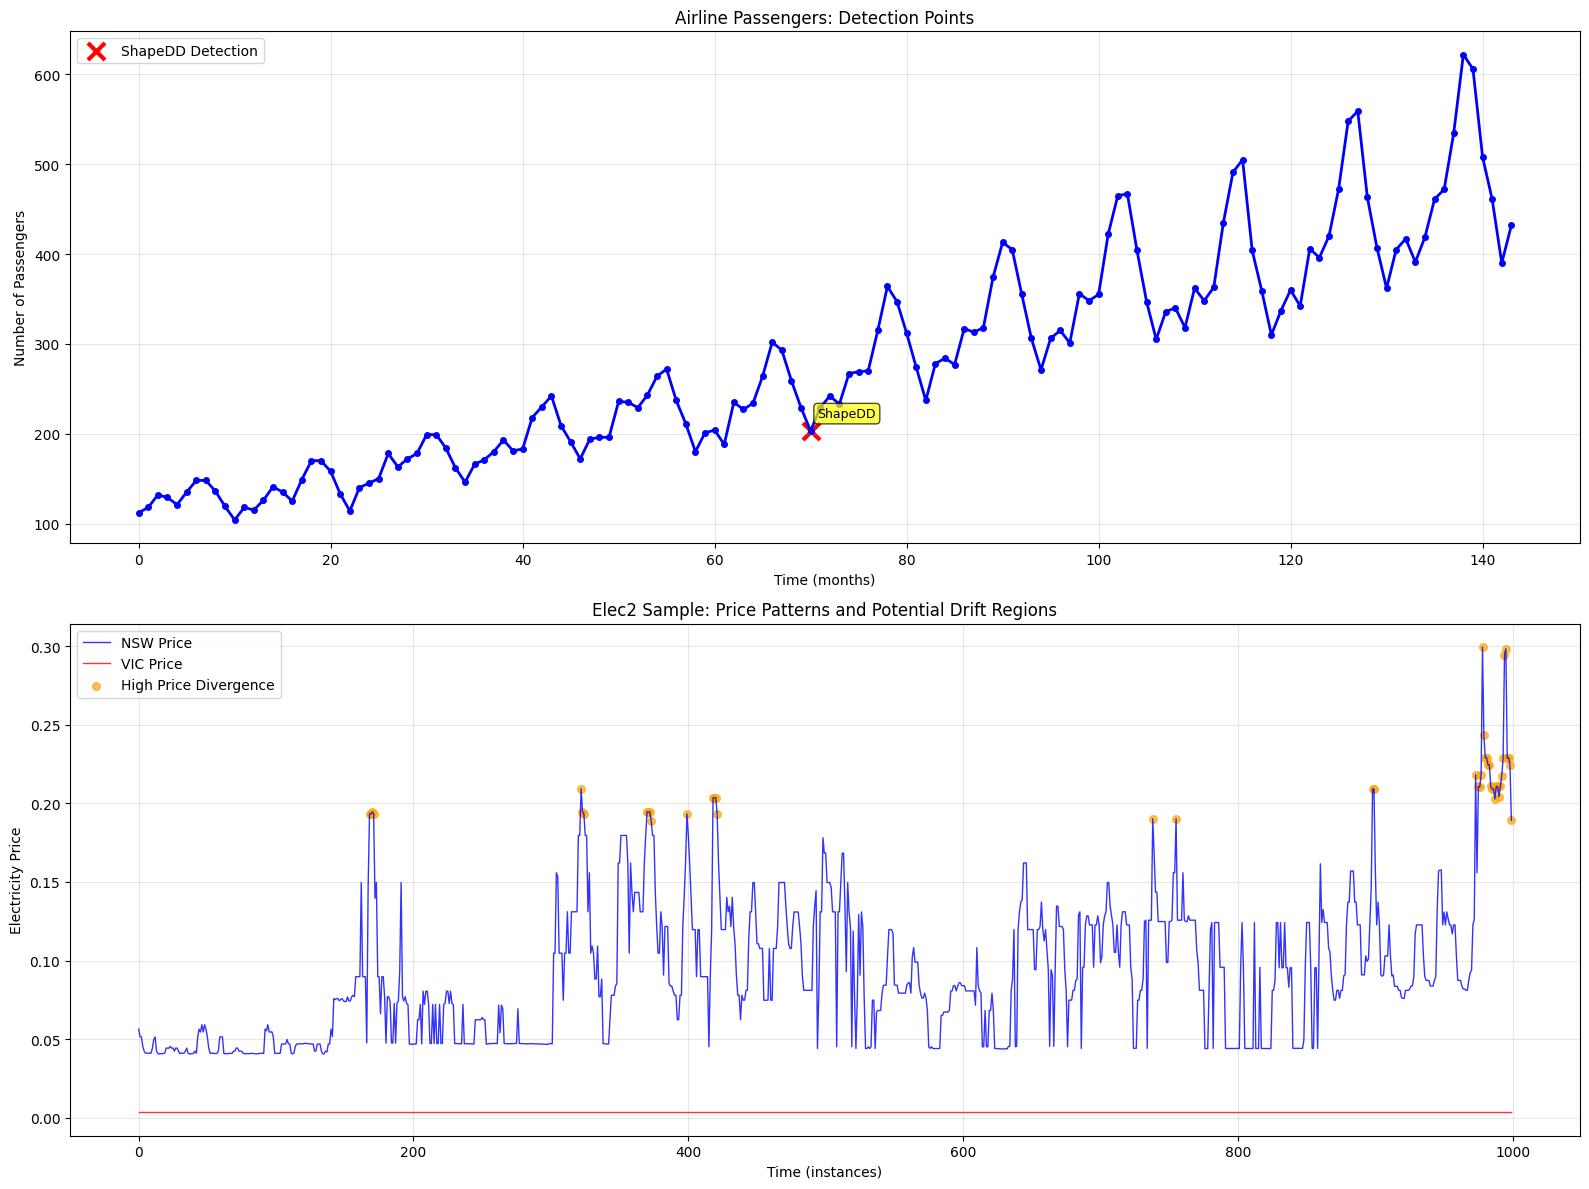


Real-world Data (Airline Passengers):
  D3        : No detections
  ShapeDD   : [70]


In [45]:
# Plot detection points along with data visualization for real-world data

fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Real-world Airline Data with Detections
time_points = range(len(df_airline_benchmark))
passengers = df_airline['passengers'].values
ax3.plot(time_points, passengers, 'b-', linewidth=2, marker='o', markersize=4)

# Add detection points from real-world analysis
for _, row in realworld_df.iterrows():
    detections = row['detections']
    if len(detections) > 0:
        detection_passengers = [passengers[d] for d in detections if d < len(passengers)]
        ax3.scatter(detections, detection_passengers, c='red', marker='x', s=150, 
                   linewidth=3, label=f"{row['method']} Detection")
        # Add method label
        for i, d in enumerate(detections):
            if d < len(passengers):
                ax3.annotate(row['method'], (d, passengers[d]), 
                           xytext=(5, 10), textcoords='offset points', fontsize=9,
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax3.set_xlabel('Time (months)')
ax3.set_ylabel('Number of Passengers')
ax3.set_title('Airline Passengers: Detection Points')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 2: Elec2 Sample Data with Potential Drift Regions
time_elec = range(len(df_elec2_sample))
ax4.plot(time_elec, df_elec2_sample['nswprice'], 'b-', linewidth=1, alpha=0.8, label='NSW Price')
ax4.plot(time_elec, df_elec2_sample['vicprice'], 'r-', linewidth=1, alpha=0.8, label='VIC Price')

# Highlight regions where prices diverge significantly (potential drift indicators)
price_diff = abs(df_elec2_sample['nswprice'] - df_elec2_sample['vicprice'])
high_divergence = price_diff > price_diff.quantile(0.95)
divergence_points = np.where(high_divergence)[0]

if len(divergence_points) > 0:
    ax4.scatter(divergence_points, df_elec2_sample['nswprice'].iloc[divergence_points], 
               c='orange', marker='o', s=30, alpha=0.7, label='High Price Divergence')

ax4.set_xlabel('Time (instances)')
ax4.set_ylabel('Electricity Price')
ax4.set_title('Elec2 Sample: Price Patterns and Potential Drift Regions')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReal-world Data (Airline Passengers):")
for _, row in realworld_df.iterrows():
    detections = row['detections']
    if len(detections) > 0:
        detection_str = f"[{', '.join(map(str, detections))}]"
        print(f"  {row['method']:<10}: {detection_str}")
    else:
        print(f"  {row['method']:<10}: No detections")


In [46]:
df_elec2_benchmark


array([[0.00000e+00, 2.00000e+00, 0.00000e+00, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       [0.00000e+00, 2.00000e+00, 2.12770e-02, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       [0.00000e+00, 2.00000e+00, 4.25530e-02, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       ...,
       [8.85000e-04, 1.00000e+00, 7.87234e-01, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       [8.85000e-04, 1.00000e+00, 8.08511e-01, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01],
       [8.85000e-04, 1.00000e+00, 8.29787e-01, ..., 3.46700e-03,
        4.22915e-01, 4.14912e-01]], shape=(1000, 8))

In [47]:
df_elec2_benchmark.shape


(1000, 8)

In [48]:
dataset_name = 'Elec2'
df_elec2_copy = df_elec2_copy.drop(columns=['class'])
df_elec2_copy = df_elec2_copy.head(5000).to_numpy()  # Use first 5000 instances for quicker evaluation

elec2_dataset_results = run_realworld_experiment(df_elec2_copy, dataset_name)

# Convert to DataFrame for analysis
elec2_realworld_df = pd.DataFrame(elec2_dataset_results)

print(f"\nReal-World Evaluation Summary:")
print(f"   Total evaluations: {len(elec2_dataset_results)}")
print(f"   Datasets: {elec2_realworld_df['dataset'].unique().tolist()}")
print(f"   Methods: {elec2_realworld_df['method'].unique().tolist()}")

# Add detection count column for consistency with synthetic results
elec2_realworld_df['detection_count'] = elec2_realworld_df.apply(
    lambda row: row.get('total_detections', len(row.get('detections', []))), axis=1
)


  Running D3
  Running ShapeDD

Real-World Evaluation Summary:
   Total evaluations: 2
   Datasets: ['Elec2']
   Methods: ['D3', 'ShapeDD']


In [49]:
elec2_realworld_df


,method,paradigm,detections,total_detections,runtime_per_instance_ms,total_runtime_s,memory_mb,data_size,dataset,detection_count
0,D3,window,[],0,0.000782,0.003912,0.000000,5000,Elec2,0
1,ShapeDD,window,"[190, 287, 384, 431, 526, 623, 721, 767, 862, ...",59,4.499795,22.498974,4669.683594,5000,Elec2,59


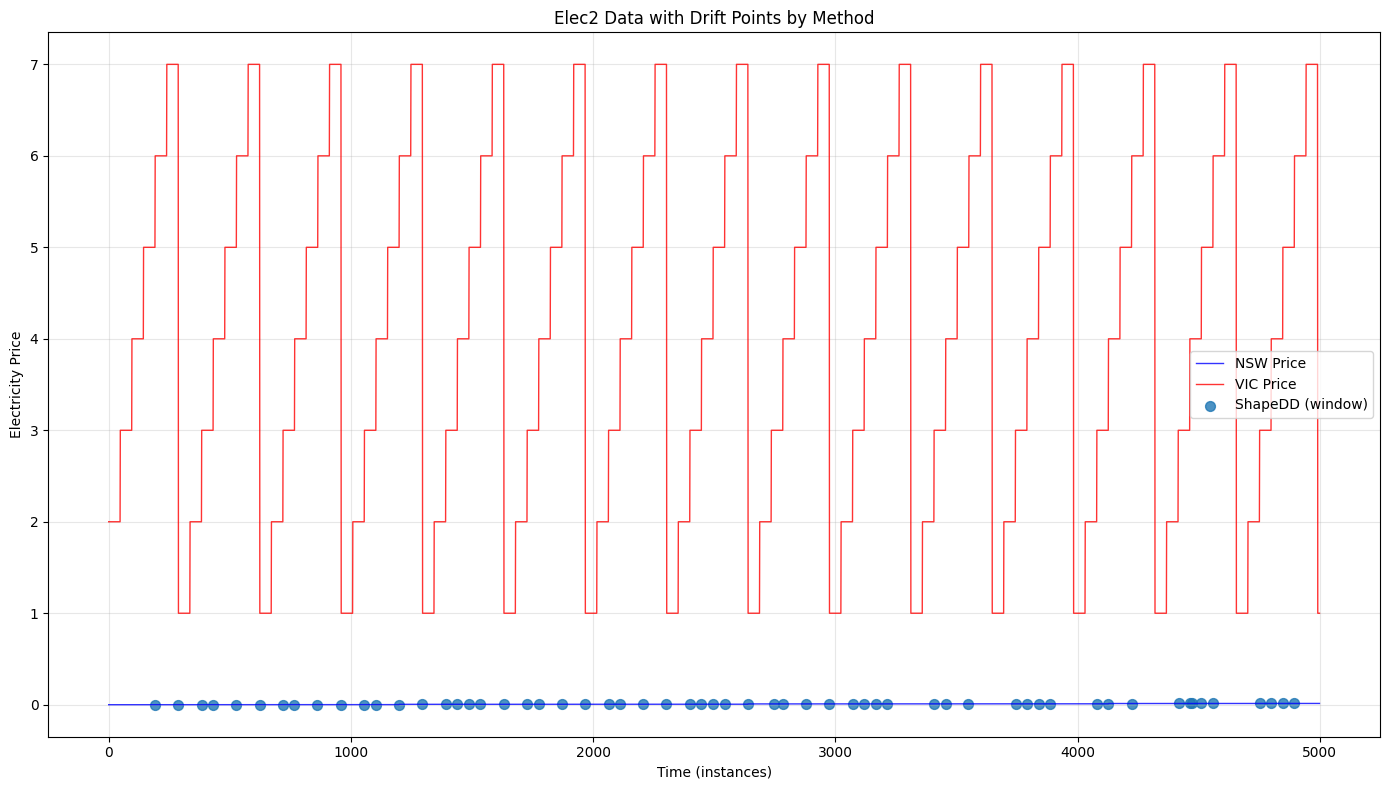

In [51]:
# Plot Elec2 data with drift points for each method
plt.figure(figsize=(14, 8))

# Plot NSW and VIC prices
plt.plot(range(len(df_elec2_copy)), df_elec2_copy[:, 0], 'b-', linewidth=1, alpha=0.8, label='NSW Price')
plt.plot(range(len(df_elec2_copy)), df_elec2_copy[:, 1], 'r-', linewidth=1, alpha=0.8, label='VIC Price')

# Plot detection points for each method
for _, row in elec2_realworld_df.iterrows():
    detections = row['detections']
    method_label = f"{row['method']} ({row['paradigm']})"
    if len(detections) > 0:
        plt.scatter(detections, [df_elec2_copy[d, 0] for d in detections], 
                    label=method_label, alpha=0.8, s=50)

plt.xlabel('Time (instances)')
plt.ylabel('Electricity Price')
plt.title('Elec2 Data with Drift Points by Method')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
